In [20]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.metrics import error_rate
import os 

import config as cfg

In [21]:
batch_size = 64

image_classes = ['cored', 'diffuse', 'CAA']

In [ ]:
train_n_validation = pd.read_csv(os.path.join(cfg.csv_dir, 'train_n_validation_multilabel.csv'))

In [27]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [28]:
np.random.seed(42)

classes = set(train_n_validation.label.values).union(set(test.label.values))
src = (ImageList.from_df(path=cfg.img_path, df=train_n_validation, folder='all')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [29]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))


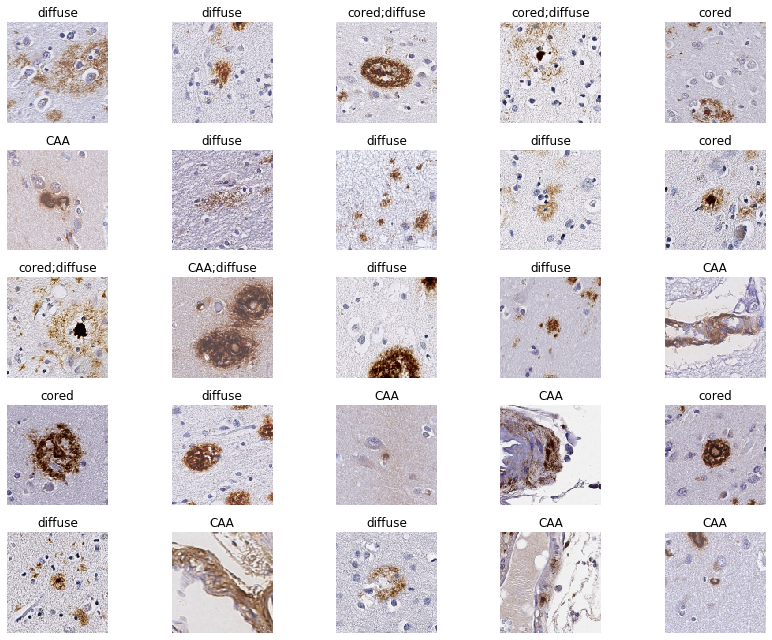

In [30]:
data.show_batch(rows=5, figsize=(12,9))

In [31]:
resnet34 = models.resnet34

In [32]:
acc_05 = partial(accuracy_thresh, thresh=0.5)
f_score = partial(fbeta, thresh=0.2)

In [33]:
learn = cnn_learner(data, resnet34, metrics=[acc_05, f_score])

In [34]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


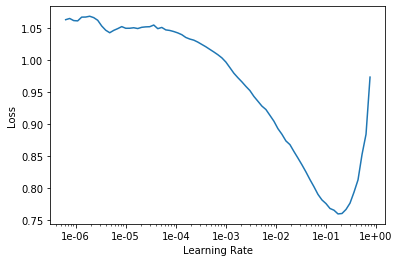

In [35]:
learn.recorder.plot()

In [37]:
lr = 1e-02

In [38]:
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.196257,0.176157,0.931331,0.911940,03:00
1,0.154360,0.141070,0.945580,0.930025,02:52
2,0.156558,0.134762,0.948456,0.934609,03:08
3,0.149118,0.129461,0.951889,0.937518,02:52
4,0.139063,0.116421,0.956588,0.943981,03:00
5,0.130377,0.111826,0.958731,0.944930,02:52
6,0.120416,0.113103,0.959723,0.946799,02:52
7,0.121204,0.103690,0.962461,0.950105,02:52
8,0.114542,0.100371,0.963987,0.951369,02:52
9,0.113823,0.099132,0.964384,0.952421,02:52


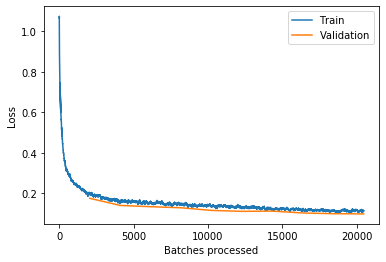

In [39]:
learn.recorder.plot_losses()

In [40]:
learn.save(os.path.join(cfg.models_dir, 'stage-1-rn34-v3'))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


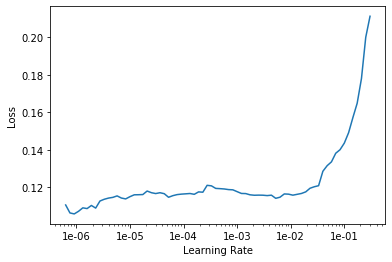

In [42]:
resnet50 = models.resnet50
learn50 = cnn_learner(data, resnet50, metrics=[acc_05, f_score])
learn.lr_find()
learn.recorder.plot()

In [43]:
lr50 = 1e-02

In [44]:
learn50.fit_one_cycle(2, slice(lr50))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.144298,0.130827,0.952186,0.938007,05:34
1,0.128029,0.109618,0.958830,0.945745,05:31


In [45]:
learn50.save(os.path.join(cfg.models_dir, 'stage-1-rn50-v3'))

In [46]:
learn50.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


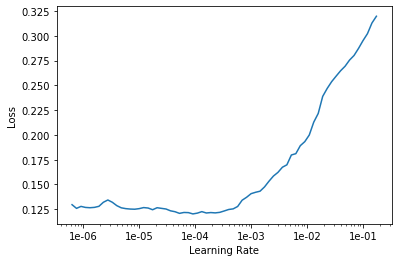

In [47]:
learn50.lr_find()
learn50.recorder.plot()

In [48]:
learn50.fit_one_cycle(5, slice(1e-5, 1e-2))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.137155,0.139620,0.949333,0.930537,07:53
1,0.125236,0.152772,0.960059,0.944449,07:45
2,0.091744,0.349414,0.970349,0.958063,07:46
3,0.074564,0.073083,0.979411,0.968622,07:46
4,0.063288,0.068320,0.981082,0.971431,07:46


In [49]:
learn50.save(os.path.join(cfg.models_dir, 'stage-2-rn50-v3'))

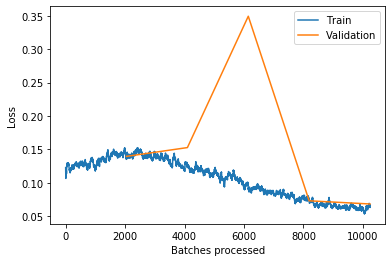

In [50]:
learn50.recorder.plot_losses()

In [51]:
learn50.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


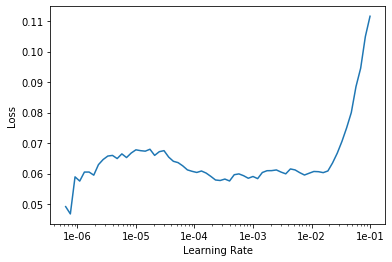

In [52]:
learn50.lr_find()
learn50.recorder.plot()

In [53]:
learn50.fit_one_cycle(2, slice(1e-4, 1e-2))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.072268,0.072741,0.980167,0.970301,05:27
1,0.071024,0.075032,0.981135,0.972245,05:30


In [54]:
learn50.save(os.path.join(cfg.models_dir, 'stage-3-rn50-v3'))

In [55]:
data_256 = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn50.data = data_256
data_256.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [56]:
learn50.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


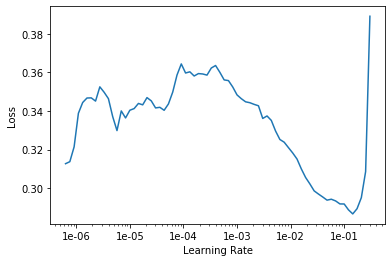

In [57]:
learn50.lr_find()
learn50.recorder.plot()

In [58]:
lr=1e-2
learn50.fit_one_cycle(3, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.124932,0.115341,0.958403,0.945981,20:52
1,0.101864,0.134240,0.966176,0.952304,20:44
2,0.096036,0.125455,0.968877,0.956562,20:31


In [59]:
learn50.save(os.path.join(cfg.models_dir, 'stage-4-256-rn50'))

In [60]:
learn50.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


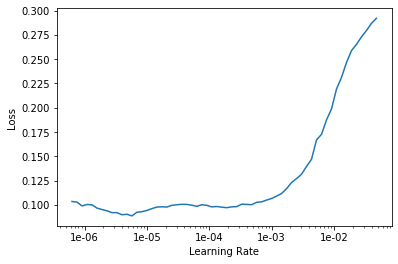

In [61]:
learn50.lr_find()
learn50.recorder.plot()

In [62]:
learn50.fit_one_cycle(2, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.097339,0.083388,0.972264,0.959751,27:48
1,0.079276,0.071440,0.978870,0.968229,27:54


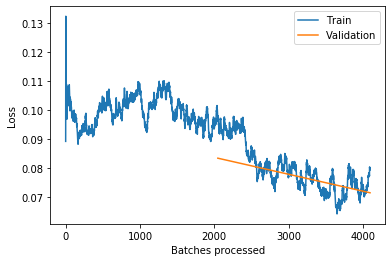

In [63]:
learn50.recorder.plot_losses()

In [64]:
learn50.save(os.path.join(cfg.models_dir, 'stage-5-256-rn50'))

In [65]:
learn50.export(os.path.join(cfg.models_dir, 'stage-5-256-rn50-exported'))